In [16]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gc
import re

from tqdm import tqdm
tqdm.pandas()

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import scale, minmax_scale
from scipy.stats import norm

import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore')
warnings.filterwarnings('ignore')

# change to path
PATH='/content/drive/My Drive/Colab Notebooks/nba/'
os.chdir(PATH)

## Read in

In [18]:
train = pd.read_csv(f'{PATH}/dataset/training_set.csv', encoding = 'ISO-8859-1')
test = pd.read_csv(f'{PATH}/dataset/holdout_set.csv', encoding = 'ISO-8859-1')

train.head()

,Engagements,Followers at Posting,Created,Type,Description
0,502093,36984682,2019-05-21 23:30:51 EDT,Video,The @raptors bench trio of @sergeibaka @norman...
1,603380,36984682,2019-05-21 22:53:33 EDT,Video,@kyle_lowry7 pulls from deep for the @raptors ...
2,603380,36984682,2019-05-21 22:19:58 EDT,Video,@k_mid22 with some english on the @bucks dime!
3,725100,36984682,2019-05-21 22:02:41 EDT,Video,Kawhi punches it home with the left on TNT!
4,661446,36984682,2019-05-21 20:47:49 EDT,Video,@giannis_an34 goes baseline early to rock the ...


In [19]:
len(train), len(test)

(7766, 1000)

## EDA on target

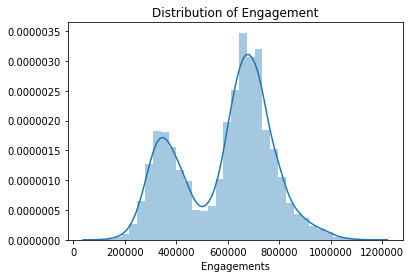

In [20]:
plt.title('Distribution of Engagement')
sns.distplot(train['Engagements'])
plt.show()

In [21]:
train.query('Engagements > 1_050_000').\
    sort_values('Engagements', ascending=False).\
    head()

,Engagements,Followers at Posting,Created,Type,Description
5921,1129585,26873604,2018-02-18 19:59:49 EST,Video,The captains meet for pregame #NBAAllStar talk...
3699,1077014,30719053,2018-09-16 12:06:15 EDT,Video,30 days from #KiaTipOff18... we flashback to @...
3876,1075434,30047470,2018-08-11 20:55:20 EDT,Video,At #1 on the TOP 60 DIMES... @kingjames! #NBAA...
5901,1067990,26873604,2018-02-18 23:32:14 EST,Video,@kingjames (29p/10r/8a) hoists the 2018 #NBAAl...
3762,1066099,30442523,2018-09-01 12:18:40 EDT,Video,Coming in at No.5...@kyrieirving SOMEHOW finds...


Highest `Engagements` at 1.1 million. Since `Engagement` is dependent on the number of followers, it would be better to take the percentage.

In [22]:
train['pct_engage'] = train['Engagements'] / train['Followers at Posting']

train.head()

,Engagements,Followers at Posting,Created,Type,Description,pct_engage
0,502093,36984682,2019-05-21 23:30:51 EDT,Video,The @raptors bench trio of @sergeibaka @norman...,0.013576
1,603380,36984682,2019-05-21 22:53:33 EDT,Video,@kyle_lowry7 pulls from deep for the @raptors ...,0.016314
2,603380,36984682,2019-05-21 22:19:58 EDT,Video,@k_mid22 with some english on the @bucks dime!,0.016314
3,725100,36984682,2019-05-21 22:02:41 EDT,Video,Kawhi punches it home with the left on TNT!,0.019605
4,661446,36984682,2019-05-21 20:47:49 EDT,Video,@giannis_an34 goes baseline early to rock the ...,0.017884


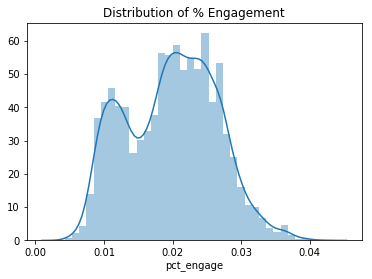

In [23]:
plt.title('Distribution of % Engagement')
sns.distplot(train['pct_engage'])
plt.show()

How closely are `Engagements` and `Followers at Posting` related?

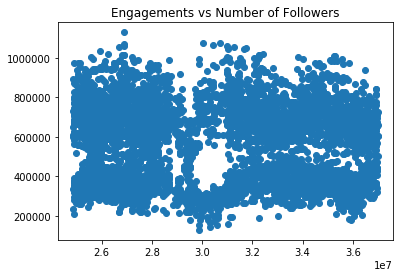

In [50]:
plt.title('Engagements vs Number of Followers')
plt.scatter(train['Followers at Posting'],
            train['Engagements'])
plt.show()

Apparently, `Engagements` and `Followers at Posting` are not quite related. Next, I will look at the descriptions on some most engaged and least engaged posts.

In [25]:
train.query('pct_engage > 0.03').\
    sort_values('pct_engage', ascending=False).\
    head(20)

,Engagements,Followers at Posting,Created,Type,Description,pct_engage
5921,1129585,26873604,2018-02-18 19:59:49 EST,Video,The captains meet for pregame #NBAAllStar talk...,0.042033
6867,1035841,25922734,2017-12-16 21:13:10 EST,Video,?? How did @kingjames do THAT?!?,0.039959
5901,1067990,26873604,2018-02-18 23:32:14 EST,Video,@kingjames (29p/10r/8a) hoists the 2018 #NBAAl...,0.039741
6100,1055161,26706824,2018-02-08 21:03:45 EST,Video,???? @kyrieirving ????,0.039509
5912,1059349,26873604,2018-02-18 22:20:39 EST,Video,@kingjames with the left! #NBAAllStar,0.039420
7217,1001632,25564228,2017-11-18 22:43:45 EST,Video,@kyrieirving... too smooth!,0.039181
7754,972546,24885537,2017-10-02 20:13:01 EDT,Video,@kyrieirving shows off the bounce for Boston! ...,0.039081
6571,1020514,26236679,2018-01-06 21:23:54 EST,Video,@kingjames takes flight! #PosterAlert,0.038896
7611,972264,25079991,2017-10-18 19:51:39 EDT,Video,@kyrieirving is introduced in Boston! #KiaTipO...,0.038767
7572,973382,25132964,2017-10-20 21:09:43 EDT,Video,?? @kingjames follows it up for the @cavs! #Ki...,0.038729


In [26]:
train.query('pct_engage < 0.01').\
    sort_values('pct_engage', ascending=True).\
    head(20)

,Engagements,Followers at Posting,Created,Type,Description,pct_engage
3933,127816,29876355,2018-08-04 00:37:27 EDT,Photo,Representing #TeamWORLD in the 2018 #NBAAfrica...,0.004278
3789,143702,30321656,2018-08-26 10:39:01 EDT,Photo,@breannastewart30 of the @seattlestorm named 2...,0.004739
641,177134,35918453,2019-04-10 01:54:20 EDT,Photo,?? Onto Game 3 ??@ipjh55s BIG night helps the...,0.004932
3713,154556,30586755,2018-09-09 14:10:31 EDT,Photo,Congratulations to the @lvaces' @aja22wilson o...,0.005053
3613,159402,31026589,2018-09-30 16:48:19 EDT,Photo,?? 3rd straight @FIBA World Cup Gold Medal ??\...,0.005138
686,185328,35857828,2019-04-07 15:21:44 EDT,Photo,The #GLeagueFinals presented by YouTube TV tip...,0.005168
3934,154757,29876355,2018-08-04 00:33:09 EDT,Photo,Representing #TeamWORLD in the 2018 #NBAAfrica...,0.005180
3787,165364,30321656,2018-08-26 17:32:20 EDT,Photo,Diana Taurasi becomes the all-time leader in p...,0.005454
524,198217,36047948,2019-04-16 11:04:36 EDT,Album,"In tonights #NBAPlayoffs action, the @orlando...",0.005499
3757,170607,30461718,2018-09-02 13:43:49 EDT,Album,Two pivotal Game 4s on the #WNBAPlayoffs sche...,0.005601


## Observations
Apparently the most engaged posts are mostly related to `@kingjames` and `@kyrieirving` while the least engaged posts are mostly related to `@wnba`.

## Preprocessing

In [0]:
def str_to_date(s, split):
    return s.split(' ')[split]
  
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)
      
def get_time_split(time):
    time_minute = time.split(':')[:2]
    return int(''.join(time_minute))
  
def get_hour(time):
    return int(time.split(':')[0])
  
def get_minute(time):
    return round(int(time.split(':')[1]), -1)

In [0]:
def preprocess(df):
    df['date'] = df.apply(lambda x: str_to_date(x['Created'], 0), axis=1)
    df['time'] = df.apply(lambda x: str_to_date(x['Created'], 1), axis=1)
    df['tz'] = df.apply(lambda x: str_to_date(x['Created'], 2), axis=1)
    
    # get more features on date
    df['date'] = pd.to_datetime(df['date'])
    
    # date
    df['date_tsfm'] = pd.to_datetime(df['date'])
    
    add_datepart(df, 'date_tsfm')

    time_df = pd.get_dummies(df['Type'], 
                         prefix='Type')

    # get only time and hour
    df['time_split'] = df['time'].apply(get_time_split)
    df['hour'] = df['time'].apply(get_hour)
    df['minute'] = df['time'].apply(get_minute)   
    
    df = pd.concat([df, time_df],
                    axis=1)
    
    return df

In [0]:
train = preprocess(train)
test = preprocess(test)

In [30]:
train.shape, test.shape

((7766, 28), (1000, 27))

In [31]:
train.head()

,Engagements,Followers at Posting,Created,Type,Description,pct_engage,date,time,tz,date_tsfmYear,date_tsfmMonth,date_tsfmWeek,date_tsfmDay,date_tsfmDayofweek,date_tsfmDayofyear,date_tsfmIs_month_end,date_tsfmIs_month_start,date_tsfmIs_quarter_end,date_tsfmIs_quarter_start,date_tsfmIs_year_end,date_tsfmIs_year_start,date_tsfmElapsed,time_split,hour,minute,Type_Album,Type_Photo,Type_Video
0,502093,36984682,2019-05-21 23:30:51 EDT,Video,The @raptors bench trio of @sergeibaka @norman...,0.013576,2019-05-21,23:30:51,EDT,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,2330,23,30,0,0,1
1,603380,36984682,2019-05-21 22:53:33 EDT,Video,@kyle_lowry7 pulls from deep for the @raptors ...,0.016314,2019-05-21,22:53:33,EDT,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,2253,22,50,0,0,1
2,603380,36984682,2019-05-21 22:19:58 EDT,Video,@k_mid22 with some english on the @bucks dime!,0.016314,2019-05-21,22:19:58,EDT,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,2219,22,20,0,0,1
3,725100,36984682,2019-05-21 22:02:41 EDT,Video,Kawhi punches it home with the left on TNT!,0.019605,2019-05-21,22:02:41,EDT,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,2202,22,0,0,0,1
4,661446,36984682,2019-05-21 20:47:49 EDT,Video,@giannis_an34 goes baseline early to rock the ...,0.017884,2019-05-21,20:47:49,EDT,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,2047,20,50,0,0,1


## EDA on features

In [32]:
train['tz'].value_counts()

EDT    3990
EST    3776
Name: tz, dtype: int64

In [33]:
train[(train['date'] < pd.datetime(2017, 11, 5)) & 
      (train['date'] > pd.datetime(2017, 3, 12))]['tz'].value_counts()

EDT    382
Name: tz, dtype: int64

Seems like we are having an equal split between `EDT` and `EST`. But after performing a check, daylight saving in year 2017 is between 3/12/2017 and 11/5/2017.  Hence, seeing that we only have `EDT` during daylight saving periods. This means we can assume 2300 EDT is the same as 2300 EST.

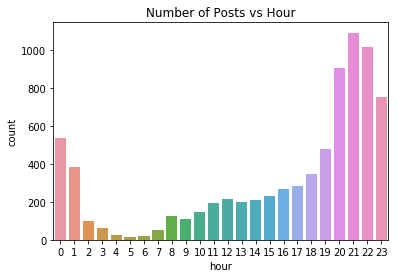

In [34]:
hour_val_cnt = train['hour'].value_counts().\
                  reset_index(name='count').\
                  rename(columns={'index':'hour'})

plt.title('Number of Posts vs Hour')
sns.barplot(x=hour_val_cnt['hour'],
            y=hour_val_cnt['count'],)
plt.show()

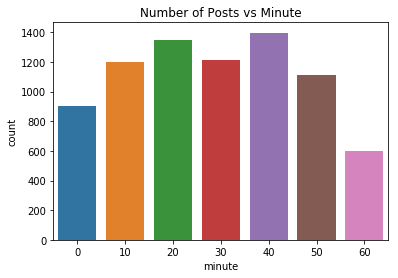

In [35]:
min_val_cnt = train['minute'].value_counts().\
                reset_index(name='count').\
                rename(columns={'index':'minute'})

plt.title('Number of Posts vs Minute')
sns.barplot(x=min_val_cnt['minute'],
            y=min_val_cnt['count'],)
plt.show()

Most posts are share between 8 PM to 12 AM EST.

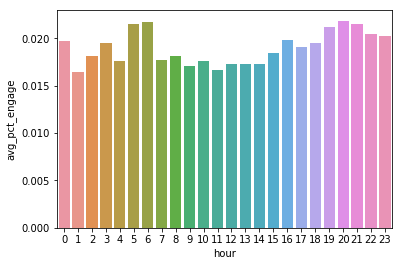

In [36]:
pct_engage_mean = train.groupby('hour')['pct_engage'].\
                          mean().\
                          reset_index(name='avg_pct_engage')

pct_engage_mean.head()

# plt.figure(figsize=(8,6))
sns.barplot(x=pct_engage_mean['hour'],
            y=pct_engage_mean['avg_pct_engage'])
plt.show()

Interestingly, posts shared between 5 AM and 6 AM have surprisingly high `pct_engage` despite fewer posts are shared between those time.

In [37]:
train.query('hour == 5').sort_values('pct_engage', ascending=False).head()

,Engagements,Followers at Posting,Created,Type,Description,pct_engage,date,time,tz,date_tsfmYear,date_tsfmMonth,date_tsfmWeek,date_tsfmDay,date_tsfmDayofweek,date_tsfmDayofyear,date_tsfmIs_month_end,date_tsfmIs_month_start,date_tsfmIs_quarter_end,date_tsfmIs_quarter_start,date_tsfmIs_year_end,date_tsfmIs_year_start,date_tsfmElapsed,time_split,hour,minute,Type_Album,Type_Photo,Type_Video
6107,918745,26706824,2018-02-08 05:04:11 EST,Video,Coming through on both ends... @kingjames SWA...,0.034401,2018-02-08,05:04:11,EST,2018,2,6,8,3,39,False,False,False,False,False,False,1518048000,504,5,0,0,0,1
7393,844329,25358849,2017-11-04 05:40:47 EDT,Video,Above the rim... with the BEST DUNK from each ...,0.033295,2017-11-04,05:40:47,EDT,2017,11,44,4,5,308,False,False,False,False,False,False,1509753600,540,5,40,0,0,1
5965,883532,26847930,2018-02-17 05:03:53 EST,Video,Who had the best DUNK at the #KickstartRisingS...,0.032909,2018-02-17,05:03:53,EST,2018,2,7,17,5,48,False,False,False,False,False,False,1518825600,503,5,0,0,0,1
6076,876494,26743966,2018-02-10 05:07:34 EST,Video,??Dwyyyyyyyyyyaaaaane Waaaaaaaaadde!,0.032774,2018-02-10,05:07:34,EST,2018,2,6,10,5,41,False,False,False,False,False,False,1518220800,507,5,10,0,0,1
3340,913655,31419673,2018-10-19 05:23:53 EDT,Video,"@kingjames puts up 26 points, 12 boards & 6 as...",0.029079,2018-10-19,05:23:53,EDT,2018,10,42,19,4,292,False,False,False,False,False,False,1539907200,523,5,20,0,0,1


## Ideas

*   Tokenize text to get NBA team's Instagram. Perform `OneHotEncoding` on names.
*   Tokenize text to get players's Instagram. Perform `OneHotEncoding` on names. Mask names with `[TEAM]_player`.
*   Time, i.e., before or after game, playoffs or regular.
*   Understand how is `Engagement` generated.


In [38]:
train[train['date']  == pd.datetime(2019, 5, 21)].sort_values('time', ascending=False).head(10)

,Engagements,Followers at Posting,Created,Type,Description,pct_engage,date,time,tz,date_tsfmYear,date_tsfmMonth,date_tsfmWeek,date_tsfmDay,date_tsfmDayofweek,date_tsfmDayofyear,date_tsfmIs_month_end,date_tsfmIs_month_start,date_tsfmIs_quarter_end,date_tsfmIs_quarter_start,date_tsfmIs_year_end,date_tsfmIs_year_start,date_tsfmElapsed,time_split,hour,minute,Type_Album,Type_Photo,Type_Video
0,502093,36984682,2019-05-21 23:30:51 EDT,Video,The @raptors bench trio of @sergeibaka @norman...,0.013576,2019-05-21,23:30:51,EDT,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,2330,23,30,0,0,1
1,603380,36984682,2019-05-21 22:53:33 EDT,Video,@kyle_lowry7 pulls from deep for the @raptors ...,0.016314,2019-05-21,22:53:33,EDT,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,2253,22,50,0,0,1
2,603380,36984682,2019-05-21 22:19:58 EDT,Video,@k_mid22 with some english on the @bucks dime!,0.016314,2019-05-21,22:19:58,EDT,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,2219,22,20,0,0,1
3,725100,36984682,2019-05-21 22:02:41 EDT,Video,Kawhi punches it home with the left on TNT!,0.019605,2019-05-21,22:02:41,EDT,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,2202,22,0,0,0,1
4,661446,36984682,2019-05-21 20:47:49 EDT,Video,@giannis_an34 goes baseline early to rock the ...,0.017884,2019-05-21,20:47:49,EDT,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,2047,20,50,0,0,1
5,322444,36955156,2019-05-21 14:02:32 EDT,Photo,Congrats to the 2018-19 NBA All-Rookie First T...,0.008725,2019-05-21,14:02:32,EDT,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,1402,14,0,0,1,0
6,722540,36955156,2019-05-21 12:30:53 EDT,Video,The @warriors locked in for four games to adva...,0.019552,2019-05-21,12:30:53,EDT,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,1230,12,30,0,0,1
7,339265,36955156,2019-05-21 08:59:02 EDT,Photo,Will the @bucks take a commanding 3-1 lead... ...,0.009180,2019-05-21,08:59:02,EDT,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,859,8,60,0,1,0
8,443330,36955156,2019-05-21 00:48:16 EDT,Photo,TAP to SHOP the @warriors Western Conference C...,0.011996,2019-05-21,00:48:16,EDT,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,48,0,50,0,1,0
9,652193,36955156,2019-05-21 00:38:18 EDT,Video,Hey @stephencurry30... that was the first time...,0.017648,2019-05-21,00:38:18,EDT,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,38,0,40,0,0,1


In [0]:
# !pip install spacy

# from spacy.lang.en import English
# from spacy.matcher import Matcher

# nlp = English()
# matcher = Matcher(nlp.vocab)

# matcher = Matcher(nlp.vocab)
# matcher.add('HASHTAG', None, [{'ORTH': '#'}, {'IS_ASCII': True}])

# docs = nlp.pipe(descriptions)

# ls_at = []
# try:
#     for doc in docs:
#         matches = matcher(doc)
#         hashtags = []
#         for match_id, start, end in matches:
#             hashtags.append(doc[start:end])
#         ls_at.append(hashtags)
# except:
#     pass 

In [0]:
def get_at_sign(s):
    try:
      ls =  re.findall(r"@(\w+)", s)
#       return ls
      return '|'.join(ls)
    except Exception as e:
      return ''
  
def get_hash(s):
    try:
      ls = re.findall(r"#(\w+)", s)
#       return ls
      return '|'.join(ls)
    except Exception as e:
      return ''

In [41]:
%%time
train['hashes'] = train['Description'].apply(get_hash)
train['at_signs'] = train['Description'].apply(get_at_sign)

CPU times: user 28.9 ms, sys: 0 ns, total: 28.9 ms
Wall time: 29.4 ms


In [42]:
train.head()

,Engagements,Followers at Posting,Created,Type,Description,pct_engage,date,time,tz,date_tsfmYear,date_tsfmMonth,date_tsfmWeek,date_tsfmDay,date_tsfmDayofweek,date_tsfmDayofyear,date_tsfmIs_month_end,date_tsfmIs_month_start,date_tsfmIs_quarter_end,date_tsfmIs_quarter_start,date_tsfmIs_year_end,date_tsfmIs_year_start,date_tsfmElapsed,time_split,hour,minute,Type_Album,Type_Photo,Type_Video,hashes,at_signs
0,502093,36984682,2019-05-21 23:30:51 EDT,Video,The @raptors bench trio of @sergeibaka @norman...,0.013576,2019-05-21,23:30:51,EDT,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,2330,23,30,0,0,1,,raptors|sergeibaka|normanpowell4|fredvanvleet
1,603380,36984682,2019-05-21 22:53:33 EDT,Video,@kyle_lowry7 pulls from deep for the @raptors ...,0.016314,2019-05-21,22:53:33,EDT,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,2253,22,50,0,0,1,,kyle_lowry7|raptors
2,603380,36984682,2019-05-21 22:19:58 EDT,Video,@k_mid22 with some english on the @bucks dime!,0.016314,2019-05-21,22:19:58,EDT,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,2219,22,20,0,0,1,,k_mid22|bucks
3,725100,36984682,2019-05-21 22:02:41 EDT,Video,Kawhi punches it home with the left on TNT!,0.019605,2019-05-21,22:02:41,EDT,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,2202,22,0,0,0,1,,
4,661446,36984682,2019-05-21 20:47:49 EDT,Video,@giannis_an34 goes baseline early to rock the ...,0.017884,2019-05-21,20:47:49,EDT,2019,5,21,21,1,141,False,False,False,False,False,False,1558396800,2047,20,50,0,0,1,,giannis_an34


In [0]:
# at_signs_ls = train['at_signs'].tolist()
# at_signs_set = set()

# for doc in tqdm(at_signs_ls):
#     for token in doc:
#         at_signs_set.add(token)
        
# hashes_ls = train['hashes'].tolist()
# hashes_set = set()

# for doc in tqdm(hashes_ls):
#     for token in doc:
#         hashes_set.add(token)

# len(at_signs_set), len(hashes_set)

In [0]:
hashes_mat = train['hashes'].str.get_dummies()
at_signs_mat = train['at_signs'].str.get_dummies()

In [0]:
top_10 = np.argsort(np.sum(hashes_mat.values, axis=0))[::-1][:10]
# np.sum(at_signs_mat, axis=0)

In [46]:
# hashes_mat.head()

[hashes_mat.columns[c] for c in top_10]

# hashes_mat.iloc[:,213]

['NBAPlayoffs',
 'ThisIsWhyWePlay',
 'NBAonABC',
 'KiaTipOff18',
 'NBAPreseason',
 'NBAFinals',
 'NBABreakdown',
 'NBAAllStar',
 'PhantomCam',
 'TripleDoubleAlert']

In [0]:
def clean_text(x):

    x = str(x)
    for punct in "/-'":
        x = x.replace(punct, ' ')
    for punct in '&':
        x = x.replace(punct, f' {punct} ')
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
        x = x.replace(punct, '')
    return x

In [0]:
train['clean_des'] = train['Description'].apply(lambda x: clean_text(x))

In [49]:
train['clean_des'].head()

0    The raptors bench trio of sergeibaka normanpow...
1    kylelowry7 pulls from deep for the raptors in ...
2           kmid22 with some english on the bucks dime
3           Kawhi punches it home with the left on TNT
4    giannisan34 goes baseline early to rock the ri...
Name: clean_des, dtype: object